In [1]:
# import library
import os
import glob
import time
import imageio
import PIL
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

print('tensorflow', tf.__version__)

tensorflow 2.6.0


In [2]:
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [4]:
print('max pixel:', train_x.max())
print('min pixel:', train_x.min())

max pixel: 255
min pixel: 0


In [5]:
# pixel normalization
train_x = (train_x - 127.5) / 127.5 # Normalize the images to [-1, 1]

print('max pixel:', train_x.max())
print('min pixel:', train_x.min())

max pixel: 1.0
min pixel: -1.0


In [6]:
# check shape
train_x.shape

(50000, 32, 32, 3)

In [7]:
train_x.dtype

dtype('float64')

In [8]:
# add channel for cnn layers
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

In [9]:
print('max pixel:', train_x.max())
print('min pixel:', train_x.min())

max pixel: 1.0
min pixel: -1.0


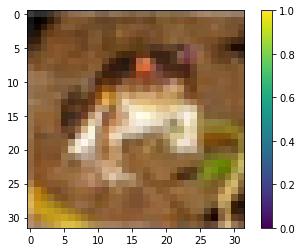

In [10]:
# visualize image
train_xplt = np.copy(train_x)
plt.imshow((train_xplt[0] + 1)/2)
plt.colorbar() # color별 수치막대 추가
plt.show()

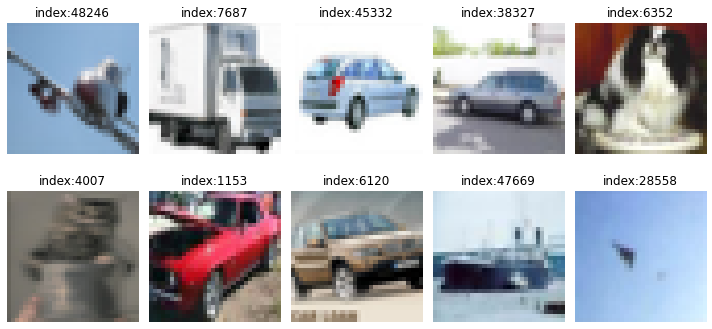

In [11]:
# visualize random 10 images
import random

plt.figure(figsize=(10,5))

# generate 10 random indices
random_indices = random.sample(range(len(train_xplt)), 10)

for i, index in enumerate(random_indices):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_xplt[index] + 1) / 2, cmap='Pastel2')
    plt.title(f'index:{index}')
    plt.axis('off') # Optional: Turn off axis labels for better visualization
    
plt.tight_layout()
plt.show()

In [12]:
# use tf.Dataset
BUFFER_SIZE = 50000  # to shuffle whole dataset : 60000
BATCH_SIZE = 256

In [13]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))

    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [15]:
# check generator
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [16]:
# random noise vector
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False) 
generated_image.shape # 첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (28, 28, 1) 사이즈 이미지가 생성되었다

TensorShape([1, 32, 32, 3])

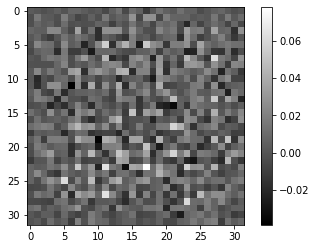

In [17]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

In [18]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
    model.add(layers.Conv2D(filters=64, kernel_size=5, strides=2, padding='same', input_shape=(32, 32, 3)))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # [[YOUR CODE]]
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))
    # [[YOUR CODE]]

    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='same'))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [19]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [20]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0064675]], dtype=float32)>

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss

In [25]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [27]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [28]:
import numpy as np
import tensorflow as tf

def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([7, 7])

In [29]:
import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

In [30]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)  # [[YOUR CODE]]

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)  # [[YOUR CODE]]

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)  # [[YOUR CODE]]

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  # [[YOUR CODE]]

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값


In [31]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # Ensure that the image is displayed in color (RGB)
        plt.imshow((predictions[i] + 1) / 2)
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                .format(os.getenv('HOME'), epoch, it))

    plt.show()


In [32]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [33]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [34]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [35]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

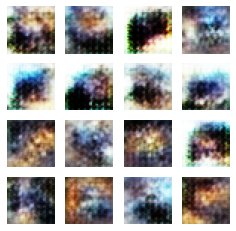

Time for training : 764 sec


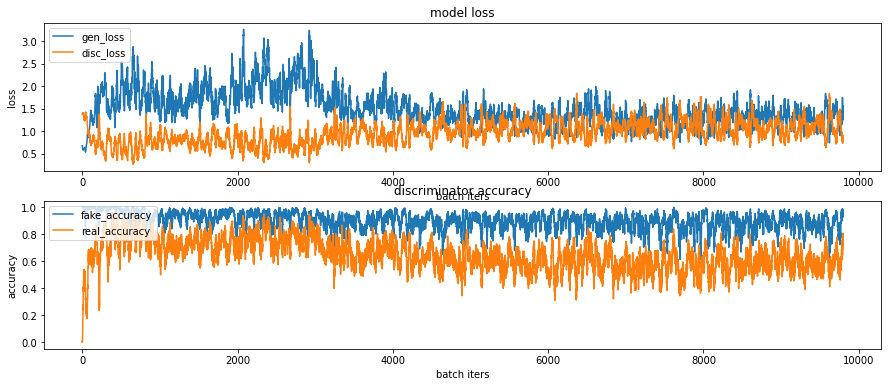

CPU times: user 13min 12s, sys: 1min 3s, total: 14min 16s
Wall time: 12min 45s


In [36]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [37]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1073623 Jan 23 08:20 /aiffel/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif


# 회고

시간이 너무 부족해서 그냥 이해보다는 어떻게 진행되는지만 본 것 같습니다.

어제 결석 여파가 컸네요 오늘 수정좀해보고 다시 올리겠습니다.

뭔가 GAN이란것에 대해 알지못하고 그냥 노드 따라 진행하고, 붙여넣기 해서 바뀐 점들만 보완하고 프로젝트를

급하게 진행 하여서 결과가 좋지 않았던 것 같습니다.

loss 값이 binary_cross_entropy 인데 1 과 0 사이가  아니라 아주 미친듯이 치고올라가는 것도 어딘가 문제가 있는 것 같습니다.

이것 저것 건드려서 값이 0.5에 가깝게 도출해내야 할 것 같습니다.

- K
    - 정말 빠르게 진행했습니다.
- P
    - 빠르게 따라 진행하다가 흑백으로 이미지가 나오고, 클리핑 이슈가 발생함
- T
    - 시각화 할때 정규화 값과, cmap 을 넣어버리는 등 다양한 문제점이 있어서 해결

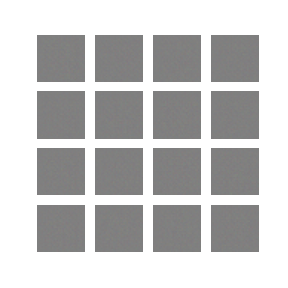

In [40]:
from IPython.display import Image

# Specify the path to the GIF file
gif_path = os.path.join(os.getenv('HOME'), 'aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif')

# Display the GIF
Image(filename=gif_path)


그래서.. 이게 뭔데..